In [1]:
using Pkg
Pkg.activate(joinpath(pwd(),".."))
using Random, Distributions, PrettyTables, Printf, Plots, Optim, ForwardDiff
Random.seed!(1234)

  Activating project at `~/Desktop/ECON 627`


TaskLocalRNG()

# (a): Generate Data

In [2]:
const θ_0 = 5

5

In [3]:
function Λ(X, θ)
    Λ = 2 * (1 .+ exp.(5 .- θ .* X)).^(-1)
    return Λ = Λ
end


Λ (generic function with 1 method)

In [4]:
function data(n)
    Z1 = rand(Normal(2,1),n)
    Z2 = rand(Normal(-2,1),n)
    V = rand(Normal(0,1),n)
    ϵ = rand(Normal(0,1),n)
    
    U = 0.9 * V + ϵ
    X = exp.(Z1 + Z2) + V

    Y = Λ(X, θ_0) + U

    return (Y = Y, X = X, Z1 = Z1, Z2 = Z2)

    
end

data (generic function with 1 method)

# (b): Criterion function

In [5]:
function Qn(Y, X, Z1, Z2, θ, A)
    n = length(Y)
    Z = [Z1 Z2]
    U = Y - Λ(X,θ)
    Qn =  1/2 * (Z' * U/n)' * A * (Z' * U/n)
    return Qn = Qn
end

Qn (generic function with 1 method)

# (c) 

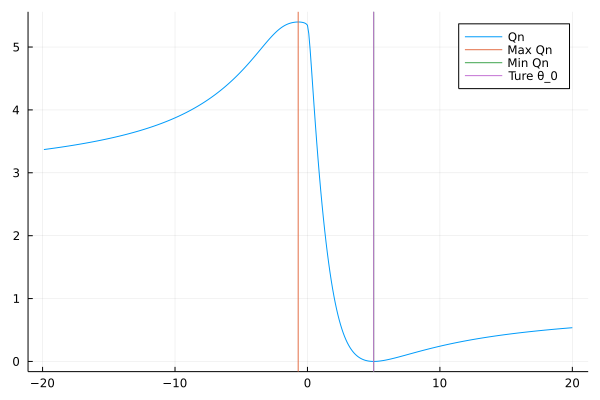

In [6]:
A = [1 0; 0 1]
n = 10^5

result = zeros((400,2))
(Y, X, Z1, Z2) = data(n)
for i in 1:400
    θ_i = -20 + 0.1 * i
    result[i,1] = Qn(Y, X, Z1, Z2, θ_i, A)
    result[i,2] = θ_i
end

plot(result[:,2], result[:,1], label = "Qn")
vline!([result[argmax(result[:,1]),2]], label = "Max Qn")
vline!([result[argmin(result[:,1]),2]], label = "Min Qn")
vline!([5.0], label = "Ture θ_0")

This criterion function successfully identified $\theta_0$, since the argmin of $Q_n$ is very close to $\theta_0$

# (d)

In [7]:
A = [1 0; 0 1]
n = 10^5

(Y, X, Z1, Z2) = data(n)

result = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [-5.0], NewtonTrustRegion(); autodiff = :forward)
θ_1 = Optim.minimizer(result)

result = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [0.0], NewtonTrustRegion(); autodiff = :forward)
θ_2 = Optim.minimizer(result)

result = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [20.0], NewtonTrustRegion(); autodiff = :forward)
θ_3 = Optim.minimizer(result)


print(θ_1, θ_2, θ_3 )

[-5.0][4.933374518169704][4.933374518165532]

We can see that, when we start from a positive value, the solutions correctly point to the optimal $\theta$, while it stays at the starting point if we starts from $-5$. I guess, with this method, Julia will only search along the direction that makes the criterion function lower. Therefore, if we start from a negative number, Julia won't search the right side. Moreover, it can also detect that there is no minimum on the left side, which makes it stop searching. 

# (e)

With efficient weighting matrix, we have:

\begin{equation}
A_n^{*'} A_n^* \longrightarrow_p A^{*'} A^* = (E[g(W_i, \theta_0) g(W_i, \theta_0)'])^{-1}  =\Omega_0^{-1}
\end{equation}

Therefore, we have:


$$
\frac{\partial^2 Q_n^*(\theta_0)}{\partial \theta \partial \theta'} = \left[ \frac{1}{n} \sum_{i = 1}^n  \frac{\partial g(W_i, \theta_0)}{\partial \theta'}  \right]' A_n^{*'} A_n^* \left[ \frac{1}{n} \sum_{i = 1}^n  \frac{\partial g(W_i, \theta_0)}{\partial \theta'}  \right] + \left[ \frac{1}{n} \sum_{i = 1}^n  \frac{\partial^2 g(W_i, \theta_0)}{\partial \theta \partial \theta'}  \right]' A_n^{*'} A_n^* \left[ \frac{1}{n} \sum_{i = 1}^n   g(W_i, \theta_0) \right] $$

$$ \longrightarrow_p E\left[ \frac{\partial g(W_i, \theta_0)}{\partial \theta'}  \right]' A^{*'} A^* E\left[ \frac{\partial g(W_i, \theta_0)}{\partial \theta'}  \right]  = \Gamma_0' \Omega_0^{-1} \Gamma_0 = V_0^{-1} \\
$$

Since we can estimate $\theta_0$ consistantly,

$$
\left( \frac{\partial^2 Q_n^*(\hat{\theta}_n)}{\partial \theta \partial \theta'} \right)^{-1} = \left( \frac{\partial^2 Q_n^*(\theta_0)}{\partial \theta \partial \theta'} + \frac{\partial^3 Q_n^*(\theta_0)}{\partial \theta \partial \theta' \partial \theta'} (\hat{\theta}_n - \theta_0) \right)^{-1}
$$

$$
\longrightarrow_p V_0
$$


# (f)

In [8]:
function TwoStepGMM(Y,X, Z1, Z2)
    A = [1 0; 0 1]
    n = length(Y)
    result1 = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A), [0.0], NewtonTrustRegion(); autodiff = :forward)
    θ_1 = Optim.minimizer(result1)
    θ_1 = θ_1[1]

    Z = [Z1 Z2]
    U = Y - Λ(X,θ_1)
    ZU = Z .* U

    A1 = (ZU' * ZU) /n
    A1 = inv(A1)

    result2 = optimize(θ -> Qn(Y, X, Z1, Z2, θ, A1), [θ_1], NewtonTrustRegion(); autodiff = :forward)
    θ_2 = Optim.minimizer(result2)
    θ_2 = θ_2[1]

    f(θ) = Qn(Y, X, Z1, Z2, θ, A1)
    V = ForwardDiff.hessian(f, [θ_2])
    V = V[1]
    V = V^(-1)

  
    return (θ_2 = θ_2, V = V)
end

TwoStepGMM (generic function with 1 method)

# (g)

In [9]:
R = 10^4
cover = zeros(3)
for i in 1:R
    (Y, X, Z1, Z2) = data(200)
    (θ, V)  = TwoStepGMM(Y, X, Z1, Z2)
    cover[1] +=   (abs(θ - θ_0) < quantile(Normal(0,1), 1 - 0.1/2) * sqrt(V/200)) /R
    cover[2] +=   (abs(θ - θ_0) < quantile(Normal(0,1), 1 - 0.05/2) * sqrt(V/200)) /R
    cover[3] +=   (abs(θ - θ_0) < quantile(Normal(0,1), 1 - 0.01/2) * sqrt(V/200)) /R
end

header = ["α = 0.1", "α = 0.05", "α = 0.01"]
cover = cover'
pretty_table(cover; header = header)




┌─────────┬──────────┬──────────┐
│ α = 0.1 │ α = 0.05 │ α = 0.01 │
├─────────┼──────────┼──────────┤
│  0.9187 │   0.9492 │   0.9795 │
└─────────┴──────────┴──────────┘


We can see that the simulated coverage probability is pretty close to their nominal coverage level.